# Apple Quality Classifier

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.decomposition import PCA
from scipy.stats import entropy

# load the dataset
from collections import Counter
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

# Functions

In [2]:
from sklearn.ensemble import AdaBoostClassifier


def run_all_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    models = {
        "LogisticRegression": LogisticRegression(),
        "SVC": SVC(),
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "KNeighborsClassifier": KNeighborsClassifier(),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        "Ada": AdaBoostClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    return pd.DataFrame(model_performance)

def automate_pca(pca_components, X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
  pca = PCA(n_components=pca_components)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_test_pca = pca.transform(X_test_scaled)
  
  models = run_all_models(X_train_pca, X_test_pca, y_train_encoded, y_test_encoded)
  print(models)
  
def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): _description_

  Returns:
      pd.DataFrame: _description_
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [3]:
df = pd.read_csv("apple_quality.csv")
df

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good
...,...,...,...,...,...,...,...,...,...
3996,3996.0,-0.293118,1.949253,-0.204020,-0.640196,0.024523,-1.087900,1.854235285,good
3997,3997.0,-2.634515,-2.138247,-2.440461,0.657223,2.199709,4.763859,-1.334611391,bad
3998,3998.0,-4.008004,-1.779337,2.366397,-0.200329,2.161435,0.214488,-2.229719806,good
3999,3999.0,0.278540,-1.715505,0.121217,-1.154075,1.266677,-0.776571,1.599796456,good


In [4]:
df.isna().sum()

A_id           1
Size           1
Weight         1
Sweetness      1
Crunchiness    1
Juiciness      1
Ripeness       1
Acidity        0
Quality        1
dtype: int64

In [5]:
df.duplicated().sum()

0

In [6]:
df.dropna(inplace=True)

In [11]:
target = df.values[:,-1]
counter = Counter(target)

for k,v in counter.items():
  per = v/len(target) * 100
  print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=good, Count=2004, Percentage=50.100%
Class=bad, Count=1996, Percentage=49.900%


### We have a balanced dataset here which is great news

<Axes: xlabel='Quality'>

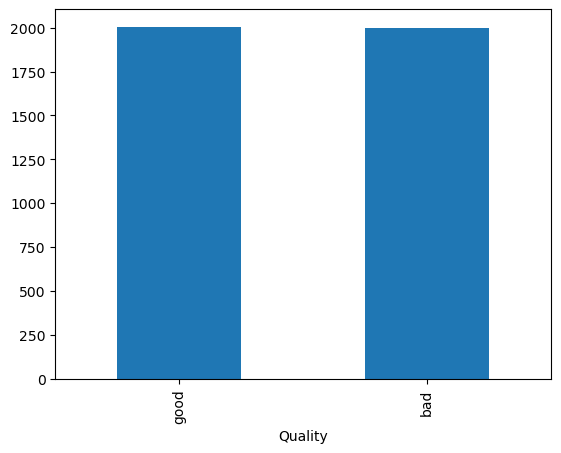

In [12]:
df['Quality'].value_counts().plot.bar()

In [13]:
df.drop("A_id", axis=1, inplace=True)

In [14]:
df.describe()

,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277
std,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427
min,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599
25%,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677
50%,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445
75%,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212
max,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837


In [21]:
df["Quality"] = df["Quality"].apply(lambda x: 1 if x == "good" else 0)

# Data Preparation

In [22]:
df["Quality"].value_counts()

Quality
1    2004
0    1996
Name: count, dtype: int64

# Visuals

<Axes: >

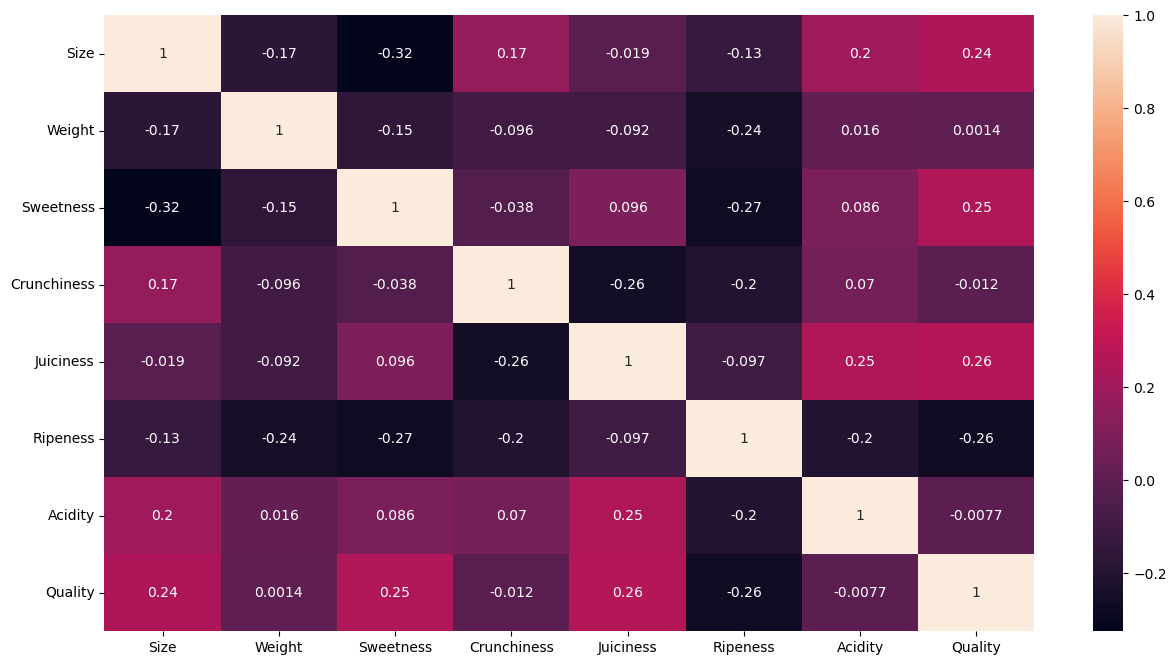

In [23]:
relations = df.corr()
plt.figure(figsize=(15,8))
sns.heatmap(data=relations, annot=True)

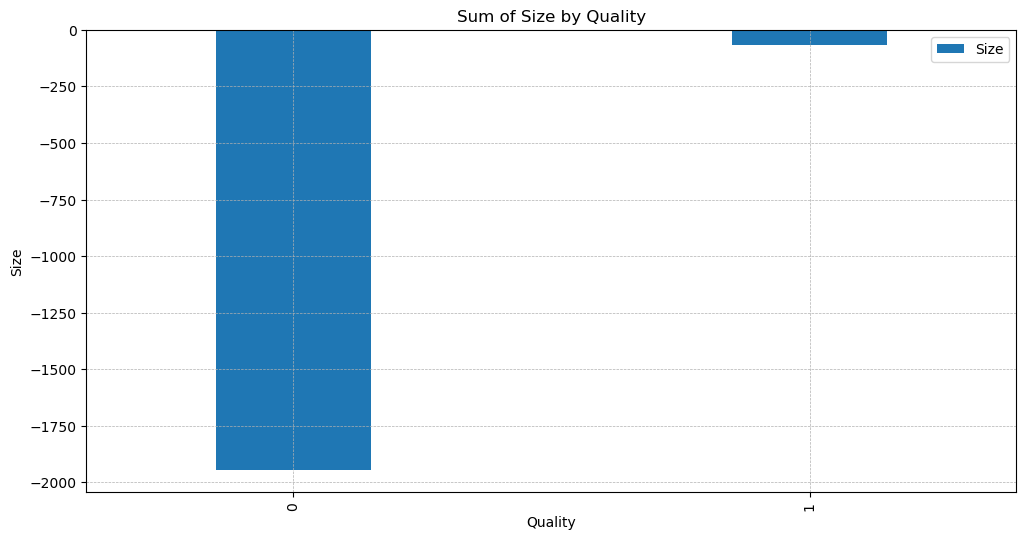

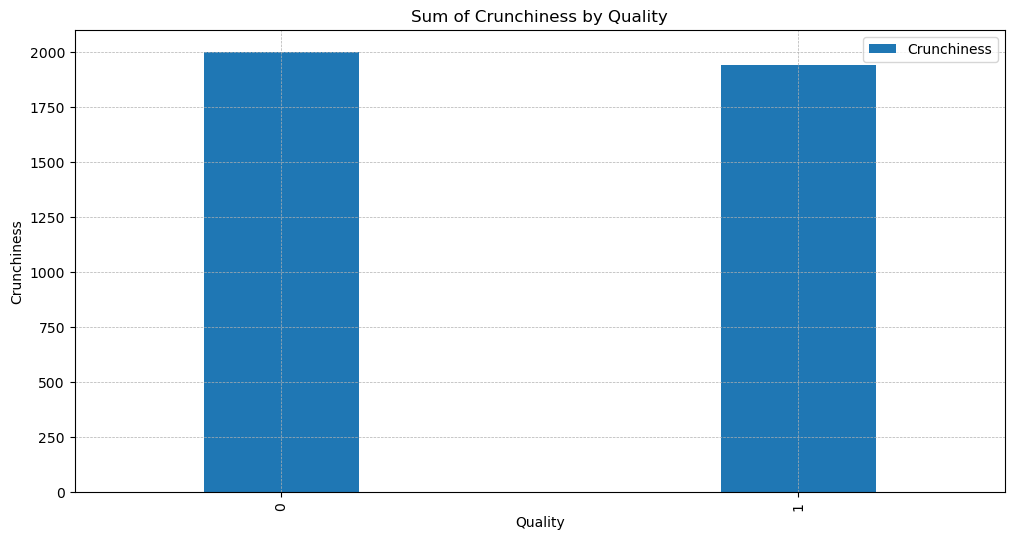

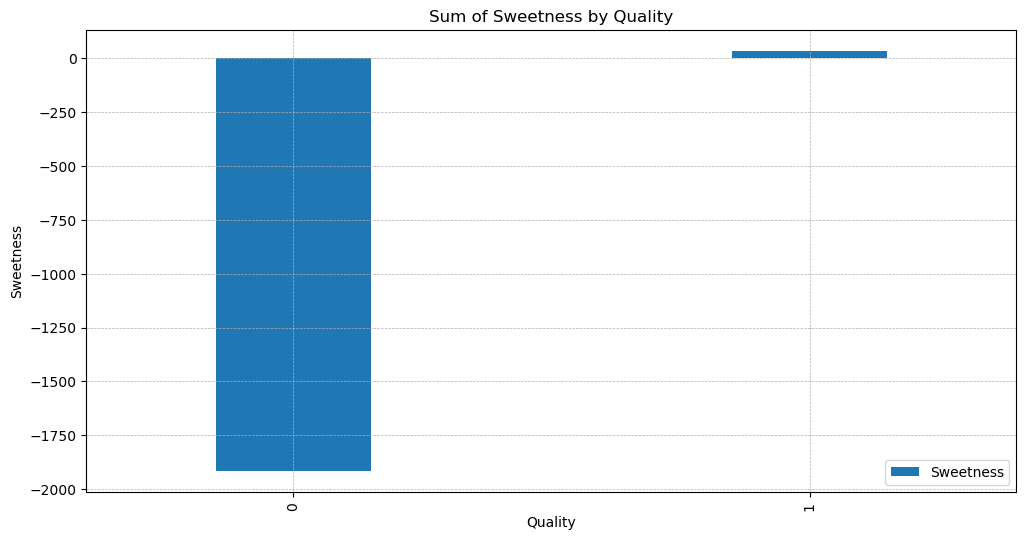

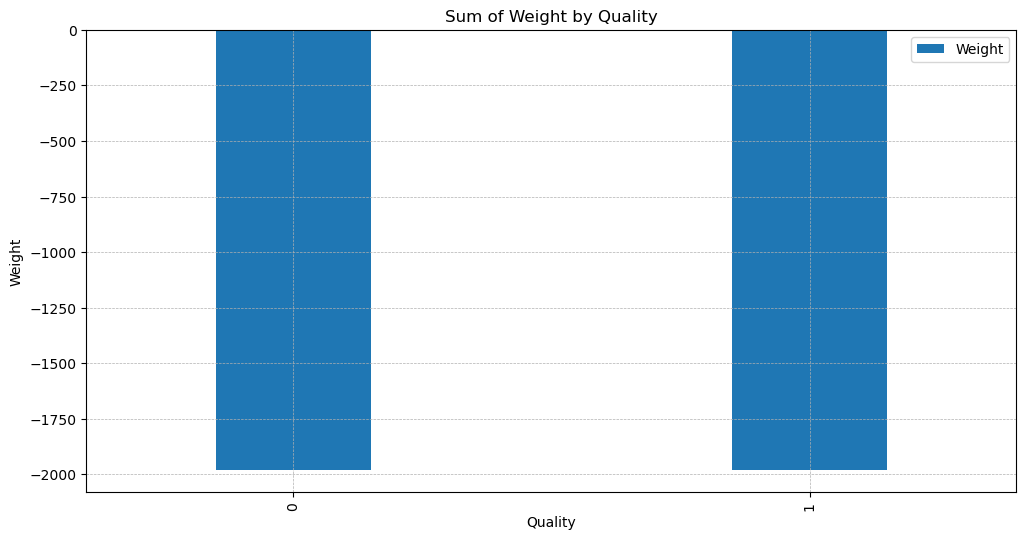

In [31]:
# Set a larger figure size and higher resolution
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

interested_columns = ["Size", "Crunchiness", "Sweetness", "Weight" ]

for col in interested_columns:
  group_df = df.groupby("Quality")[col].sum().reset_index()
  group_df.plot(kind="bar", x="Quality", y=col, width=0.3)
  plt.xlabel("Quality")
  plt.ylabel(f"{col}")
  # Add gridlines
  plt.grid(True, which='both', linestyle='--', linewidth=0.5)
  plt.title(f"Sum of {col} by Quality")

  # Show the plot
  plt.show()

In [32]:
df_width= len(df.columns)
rows = (df_width +3)//4
plt.figure(figsize=(16,16))

for idx, col in enumerate(df.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(df[col], kde=True)
  plt.title(f"Distribution of {col}")
  plt.tight_layout()
  plt.plot()

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_18677/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_18677/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_18677/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_18677/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_18677/1878150304.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
